Цель работы: создать легковесный классификтор, который по заданному тексту комментария мог бы определить, к каким типам он относится.

Для начала определимся, каким именно способом мы будем пытаться достичь поставленной цели. Когда имеется какой-то текст, то самое первое, что может прийти в голову, это отобразить слова в вектора. Если верить интернету, word2vec, обученный на огромных текстовых данных, работает очень и очень неплохо. Тем не менее, такой классификатор не будет легковесным, ведь нам нужно хранить отображение из множества слов в линейное пространство.
Тогда возникает идея смотреть лишь на некоторые ключевые слова, наиболее свойственные для каждого конкретного типа. Кажется, что если брать текст и смотреть, насколько часто в нем возникают слова, наиболее употребляемые в комментариях какого-то конкретного типа, то это будет не таким уж и плохим решением. По крайней мере в предельных случаях это совсем очевидно: если в тексте почти все слова бранные, то вряд ли сам по себе комментарий является нейтральным (исключение: если комментатор просто процитировал другой комментарий), и наоборот, если в тексте совсем не встречается слов, свойственных данному типу, то с большой вероятностью комментарий к этому типу и не относится. Что ж, давайте попробуем развить эту идею.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import collections
import string

Напишем ф-цию, которая по тексту возвращает список слов. Сразу выкинем все цифры. Кажется вполне логичным, что они не должны влиять на тип комментария. Также будем считать, что и слова, чья длина меньше или равняется двум, тоже на смысл текста большого влияния не оказывают (это в основном местоимения, артикли, междометия и пр.)

In [2]:
def word_list(text):
    symbols_to_delete = string.punctuation + '\n' + '1234567890'
    translator = str.maketrans(symbols_to_delete, ' '*len(symbols_to_delete))
    return [word.lower() for word in text.translate(translator).split(' ') if len(word) > 2]

Считаем датасет и выведем первые 5 строк.

In [3]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Сразу удалим столбец id, очевидно, что он нам не понадобится.

In [4]:
data.drop('id', axis=1, inplace=True)

Текст комментариев заменим на списки слов.

In [5]:
data.comment_text = [word_list(x) for x in data.comment_text]

Добавим еще столбец neutral, который понадобится нам в дальнейшем. Он равен 0 тогда и только тогда, когда комментарий не относится ни к одному из шести "агрессивных" типов.

In [6]:
data = data.assign(neutral=(1 - data['toxic'])*(1 - data['severe_toxic'])*(1 - data['obscene'])*(1 - data['threat'])*(1 - data['insult'])*(1 - data['identity_hate']))

Для удобства запишем названия типов в список. Далее, опять же для удобства, заменим 0 на -1.

In [7]:
agressive_comment_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in agressive_comment_types:
    data[t][data[t] == 0] = -1
data['neutral'][data['neutral'] == 0] = -1
data.head(10)

/home/skachkov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/skachkov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,"[explanation, why, the, edits, made, under, us...",-1,-1,-1,-1,-1,-1,1
1,"[aww, matches, this, background, colour, seemi...",-1,-1,-1,-1,-1,-1,1
2,"[hey, man, really, not, trying, edit, war, jus...",-1,-1,-1,-1,-1,-1,1
3,"[more, can, make, any, real, suggestions, impr...",-1,-1,-1,-1,-1,-1,1
4,"[you, sir, are, hero, any, chance, you, rememb...",-1,-1,-1,-1,-1,-1,1
5,"[congratulations, from, well, use, the, tools,...",-1,-1,-1,-1,-1,-1,1
6,"[cocksucker, before, you, piss, around, work]",1,1,1,-1,1,-1,-1
7,"[your, vandalism, the, matt, shirvington, arti...",-1,-1,-1,-1,-1,-1,1
8,"[sorry, the, word, nonsense, was, offensive, y...",-1,-1,-1,-1,-1,-1,1
9,"[alignment, this, subject, and, which, are, co...",-1,-1,-1,-1,-1,-1,1


Напишем ф-цию, которая по типу комментария возвращает слова, встречающиеся чаще всего в сообщениях данного типа.

In [8]:
def get_most_popular_words(msg_type, length=100):
    words = collections.defaultdict(int)
    for comment_text in data.loc[data[msg_type] == 1].comment_text:
        for word in comment_text:
            words[word] += 1
    counter = collections.Counter(words)
    return dict(counter.most_common(length))

Получим по 100 самых популярных слов для каждого типа и еще 500 для "нейтральных" комментариев.

In [9]:
pop_agressive_words = dict()
for t in agressive_comment_types:
    pop_agressive_words[t] = get_most_popular_words(t)
pop_neutral_words = get_most_popular_words('neutral', 500)

Выведем, например, слова, наиболее типичные для threat.

In [10]:
print(pop_agressive_words['threat'])

{'you': 2030, 'die': 1168, 'will': 840, 'ass': 772, 'and': 601, 'the': 516, 'your': 505, 'kill': 504, 'going': 294, 'wikipedia': 200, 'yourself': 194, 'block': 170, 'must': 167, 'fuck': 166, 'jim': 158, 'wales': 157, 'supertr': 152, 'that': 151, 'are': 140, 'fucking': 138, 'ban': 132, 'don': 131, 'page': 129, 'talk': 113, 'murder': 107, 'live': 102, 'for': 101, 'fuckin': 101, 'this': 96, 'rvv': 96, 'blank': 94, 'edie': 90, 'lifetime': 87, 'again': 86, 'out': 85, 'have': 82, 'pathetic': 81, 'forever': 80, 'wiki': 80, 'real': 80, 'over': 79, 'with': 78, 'fool': 78, 'respect': 76, 'all': 74, 'org': 71, 'stephen': 71, 'shit': 70, 'get': 69, 'hawkinghttp': 69, 'bitch': 68, 'hope': 65, 'take': 65, 'off': 62, 'not': 61, 'what': 56, 'like': 53, 'who': 53, 'dust': 53, 'filter': 53, 'can': 52, 'steal': 52, 'continue': 51, 'password': 51, 'know': 50, 'just': 49, 'down': 47, 'gonna': 47, 'life': 45, 'then': 44, 'death': 44, 'time': 43, 'rape': 43, 'should': 42, 'youcaltlas': 42, 'hell': 40, 'but':

Видим, что попало много "мусорных" слов, т.е. которые часто встречаются не только в данном классе, а вообще в целом в английском языке (you, will, and, the, ...). Попытаемся отсеять такие слова с помощью pop_neutral_words (собственно, только для этого мы его и создали).

In [11]:
for t in agressive_comment_types:
    pop_agressive_words[t] = {k:v for k, v in pop_agressive_words[t].items() if k not in pop_neutral_words.keys()}

Выведем получившееся.

In [12]:
for t in agressive_comment_types:
    print(t)
    print(pop_agressive_words[t])

toxic
{'fuck': 9937, 'shit': 3624, 'nigger': 3300, 'fucking': 3288, 'suck': 3235, 'ass': 2941, 'hate': 2631, 'gay': 2239, 'die': 2082, 'faggot': 2017, 'fat': 1970, 'moron': 1861, 'bitch': 1787, 'cunt': 1544, 'sucks': 1443, 'stupid': 1439, 'pig': 1355, 'jew': 1351, 'dick': 1304, 'penis': 1239, 'bullshit': 1139, 'asshole': 1043, 'wanker': 1035, 'dont': 1031, 'fag': 1019, 'bark': 1001, 'balls': 1000, 'idiot': 951, 'sex': 948, 'cock': 940}
severe_toxic
{'fuck': 7304, 'suck': 2535, 'ass': 2115, 'shit': 1885, 'faggot': 1571, 'fucking': 1456, 'die': 1156, 'bitch': 1113, 'nigger': 1012, 'sucks': 961, 'cunt': 834, 'cock': 681, 'fucksex': 624, 'yourselfgo': 621, 'dick': 596, 'fucker': 588, 'kill': 580, 'asshole': 522, 'cocksucker': 510, 'piece': 502, 'penis': 490, 'mothjer': 489, 'bastard': 481, 'gay': 477, 'eat': 431, 'bitches': 430, 'huge': 424, 'shut': 407, 'fat': 406, 'damn': 398, 'rape': 383, 'dog': 377, 'stupid': 369, 'offfuck': 360, 'mexicans': 358, 'anal': 350, 'pro': 349, 'hanibal': 348

Видим, что теперь всё стало гораздо лучше, хотя всё еще есть некоторые слова, которые на первый взгляд кажутся нейтральными (например, eat в severe_toxic или forever в threat). Хотелось бы такие слова исключить. Есть два способа. Можно посмотреть на всё это дело глазками и почистить списки ручками. Однако мы так делать не будем. И не потому, что это бесперспективный подход. Напротив, скорее всего он бы сработал лучше других. Просто при таком подходе мы получим уже не работу по машинному обучению, а по сути просто построение некотрой модели, основываясь чисто на человеческом умении классифицировать текст. Хотелось бы, чтобы классификатор как-то сам мог обучиться на имеющихся данных.  
Итак, второй подход состоит в том, чтобы произвести отбор признаков (в данном случае слова являются признаками). И вот теперь мы переходим к модели нашего классификатора.  
Что нам нужно сделать? Нам нужно по тексту уметь определять, к каким типам он относится, а к каким нет. Т.е. по сути нам нужны 6 (по количеству типов) бинарных классификаторов.  
Идея состоит в том, чтобы присвоить каждому слову еще и некоторую значимость. В идеале у слов вроде eat, forever, lifetime и т.п. она была бы 0, т.е. они вообще никак не учитывались, а дальше уже чем слово типичнее для данного класса, тем больше значимость.  
Если говорить более строго, объектом в нашем случае является входной текст, его вектор признаков - это вектор $(x_1, ..., x_n)$, где $x_i$ - это количество раз, которое i-e слово из списка популярных для данного типа слов (а мы помним, что у нас для каждого типа свой классификатор, т.е. и признаки для каждого типа свои) встречается во входном тексте, а значимости - это коэффициенты линейного классификатора.  
Составим только сам список слов.

In [13]:
pop_agressive_words = {k: list(v.keys()) for k, v in pop_agressive_words.items()}

## Модель

Итак, модель. Ответом нашего классификатора на текст будет $sign(w_1x_1 + ... w_nx_n + w_{n+1})$, где $p \in (-1, 1)$. $w_i$ ($i = 1...n$)  - веса, но в данном случае "значимости", поэтому мы наложим ограничение $w_i \geq 0$ $i = 1...n$. Ну действительно, кажется не очень логичным, что наличие какого-нибудь слова, часто встречающегося в представителях данного класса, может уменьшить вероятность принадлежности к этому классу.    
В качестве ф-ции потерь, значение которой мы будем пытаться минимизировать, возьмем $E = \sum [M_i < 0]$, где $ M_i = y_i \langle w, x_i \rangle $ - отступ на i-ом объекте, N - кол-во объектов. Минимизация такой ф-ции крайне затруднительна из-за того, что она не является гладкой. Поэтому заменим $E$ на $\sum log(1 + e^{-M_i})$. Минимизация такой ф-ции приведет и к минимизации исходной. Теперь с уменьшением Е не просто уменьшается число ошибок, но еще и максимизируются отступы, т.е. классификатор старается подстроиться так, чтобы объекты обучающей выборки находились как можно дальше от разделяющей плоскости.  
Посмотрим на то, сколько у нас всего комментариев, и сколько их них "нейтральных".

In [14]:
print(len(data))
print(len(data.loc[data['neutral'] == 1]))
print(len(data.loc[data['neutral'] == 1])/len(data))

159571
143346
0.8983211235124177


Видим, что "нейтральных" подавляющее большинство. Это значит, что если в функции потерь одинаково учитывать слагаемые, соответствующие объектам класса и остальным, то есть опасность, что обучение не будет объективным: объекты нашего класса вносят слишком маленькую поправку в ф-цию ошибок. Даже если классификатор на любой вход будет выдавать -1, точность его будет весьма высока, а ф-ция ошибки - маленькой. Это наводит на мысль, что штраф за неправильные ответы на не "нейтральных" объектах должен быть существенно выше, чтобы наш классификатор "боялся" ошибиться на этих 10% так же, как и на остальных 90%. Посчитаем долю классов в выборке.

In [15]:
proportion = dict()
for t in agressive_comment_types:
    proportion[t] = round(len(data.loc[data[t] == 1])/len(data), 4)
print(proportion)

{'toxic': 0.0958, 'severe_toxic': 0.01, 'obscene': 0.0529, 'threat': 0.003, 'insult': 0.0494, 'identity_hate': 0.0088}


Для каждого типа представим комментарии в виде векторов признаков. Последний признак - константная -1. Сделано это для удобства, чтобы не возиться отдельно со свободным членом.

In [16]:
def find_enterances(words_list, comment_type):
    global pop_agressive_words
    enterance = np.zeros(len(pop_agressive_words[comment_type]) + 1)
    enterance[-1] = -1
    for word in words_list:
        #print(word)
        word_id = -1
        for i, val in enumerate(pop_agressive_words[comment_type]):
            if val == word:
                word_id = i
                break
        if word_id >= 0:
            enterance[word_id] += 1
    return enterance

In [17]:
words_enterance = dict()
for t in agressive_comment_types:
    enterances = []
    for comment_text in data.comment_text:
        enterances.append(find_enterances(comment_text, t))
    words_enterance[t] = enterances

Для более быстрой работы с датасетом, сделаем его обычным двумерным массивом.

In [18]:
data = list(data.unstack())
k = int(len(data)/8)
data = [[data[i + k], data[i + 2*k], data[i + 3*k], data[i + 4*k], data[i + 5*k], data[i + 6*k]] for i in range(k)]
types_to_ids = {v : k for k, v in dict(enumerate(agressive_comment_types)).items()}

Теперь можно обучаться. $\frac{\partial E}{\partial w_j} = -\sum \frac{1}{1 + e^{M_i}}\frac{\partial M_i}{\partial w_j} = -\sum_{i = 1}^{N} \frac{y_ix_j}{1 + e^{M_i}}$  
Обучаться будем методом градиентного спуска. При этом учтем, что мы не хотим, чтобы веса были отрицательными. Заметим, что на свободный член также можно наложить это ограничение, ведь если он вдруг оказался бы меньше нуля, то вся сумма всегда была > 0, а значит, наш классификатор на любой вход отвечал бы "да".

In [19]:
def precision_recall(comment_type):
    global data, weights, words_enterance
    TP = 0 #True positive
    FP = 0 #false positive
    TN = 0 #true negative
    FN = 0 #false negative
    for i in range(len(data)):
        y = data[i][types_to_ids[comment_type]]
        a = np.sign(np.dot(weights[comment_type], words_enterance[comment_type][i]))
        if a == 1:
            if y == 1:
                TP += 1
            else:
                FP += 1
        else:
            if y == 1:
                FN += 1
            else:
                TN += 1
    pr = TP/(TP + FP)
    rec = TP/(TP + FN)
    return pr, rec

def train(comment_type, epochs_num = 5, eta = 0.1, return_errors = False):
    global data, words_enterance, proportion
    errs = []
    weights = np.zeros(len(words_enterance[comment_type][0]))
    for epoch in range(epochs_num):
        err = 0
        dw = np.zeros(len(weights))
        for i in range(len(data)):
            y = data[i][types_to_ids[comment_type]]
            M = y*np.dot(weights, words_enterance[comment_type][i])
            if M <= 0:
                err += 1
            c = 1 - proportion[comment_type] if y == 1 else proportion[comment_type]
            dw += c*y*words_enterance[comment_type][i]/(1 + np.exp(M))
        weights += eta*dw
        weights[weights < 0] = 0 #не позволяем весам быть отрицательными
        errs.append(err/len(data))
    if return_errors:
        return weights, errs
    else:
        return weights

Возьмем, например, eta = 1 для toxic.

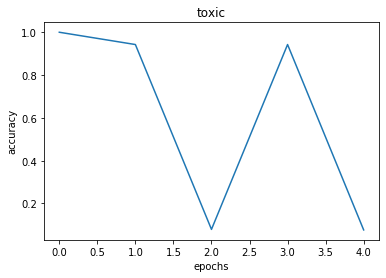

(0.6302434328152936, 0.5992546096508434)


In [20]:
weights = dict()

weights['toxic'], errs = train('toxic', return_errors=True, eta=1)
plt.plot(range(len(errs)), errs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('toxic')
plt.show()
print(precision_recall('toxic'))

Функция ошибки не монотонно убывает, а ведет себя вообще непонятно как. Видимо, мы взяли слишком большое eta. Попробуем взять eta поменьше.

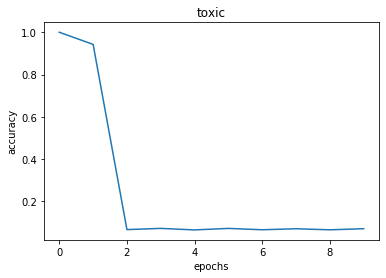

(0.7251393634238447, 0.5273309794690728)


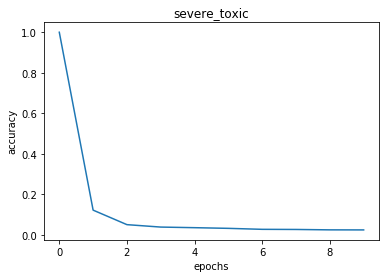

(0.25878949710725413, 0.729153605015674)


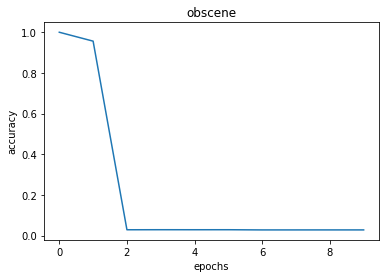

(0.7889633537715671, 0.6548703988637709)


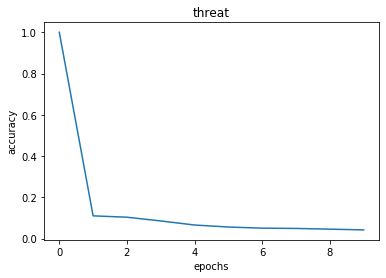

(0.04875200700627646, 0.698744769874477)


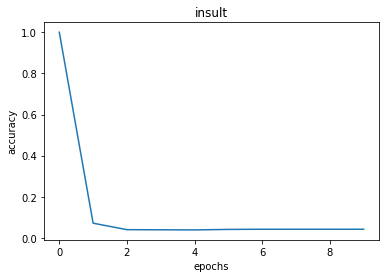

(0.5672598651486681, 0.6515170750285642)


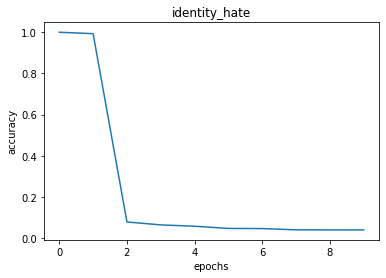

(0.13684825471009202, 0.6669039145907474)


In [21]:
for t in agressive_comment_types:
    weights[t], errs = train(t, return_errors=True, eta=0.0003, epochs_num=10)
    plt.plot(range(len(errs)), errs)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(t)
    plt.show()
    print(precision_recall(t))

Как можно видеть, все графики монотонно убывают, значит eta не слишком большая ни для одного классификатора. Все они быстро стабилизируется, поэтому увеличивать число эпох смысла нет. Тем не менее, значения precision и recall очень удручают. И если recall хотя бы не опускается ниже 50%, то вот precision никуда не годится. Что ж, отрицательный результат есть тоже результат. Надо бы понять, почему он такой.  
Возможно, сама по себе модель плохо годится. Может быть, нужно обучаться несколько хитрее. Вполне возможно, что мы попадаем в некоторый локальный минимум, который на самом деле далек от глобального. Может быть, где-то была допущена досадная ошибка, однако отыскать ее, к сожалению, не удалось.    
В любом случае, загрузим тестовый датасет и попробуем применить классификатор на нем.

In [22]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Напишем наконец главную ф-цию:

In [23]:
def classify(text, *types):
    global agressive_comment_types, weights
    ans = dict()
    words = word_list(text)
    if len(types) == 0:
        types = agressive_comment_types
    for t in types:
        enterances = find_enterances(words, t)
        ans[t] = np.sign(np.dot(weights[t], enterances))
    return ans

Отклассифицируем тексты.

In [24]:
for t in agressive_comment_types:
    test_data[t] = [classify(text, t)[t] for text in test_data.comment_text]

Случайным образом выберем по 3 представителя.

In [25]:
for t in agressive_comment_types:
    print(t)
    for text in np.random.choice(test_data.loc[test_data['identity_hate'] == 1].comment_text, 3):
        print(text)
    print('-------------------------')

toxic
:American imperialist.  Learn to fucking spell properly. —  •
SHUT UP!!!! I CAN't TAKE YOUR SHIT ANYMORE!!!! IT's ALWAYS SPAGHETTI THIS, AND TOASTERS THAT! WHY WON't YOU FUCKING STOP???!!! -
":::Then it's high time it wasn't considered ""highly controversial"". It's just another word after all, and words can only have the power you give them. I'm rather fed up with all the middle-American prudishness around here, and I will kick against whenever I feel like it. I'm reminded about some objections to the use of the word slut in a quoted translation in an article I worked on recently. Fucking ridiculous.    

 "
-------------------------
severe_toxic
==Fuck You Mr. Wales== 

 That is all.
*Holy fuck-a-bucket, it sure does. Who's got the popcorn? (PSKeeps, THIS is why I want nuffin-but-nuffin to do with adminship. Until the revolution comes, at leastwhich, after this incomprefuckinghensifuckingbility, might be WAY sooner than later.)
Fictional Jews == 

 Why did anyone write him as a

## Попытка №2
Что ж, может быть стоит попытаться рассмотреть другую модель? Например, пусть ответом классификатора будет $[tanh(w_1x_1 + ... + w_nx_n + w_{n + 1}) > p]$ где $p \in (-1, 1)$. Ф-цией ошибки возьмем $ \sum (tanh(w_1x_1 + ... + w_nx_n + w_{n + 1}) - y_i)$, где $y_i$ - ответ на i-ом объекте выборки ($\pm1$). Т.е. мы хотим, чтобы на объектах класса классификатор выдавал значение, как можно более близкое к 1, а на остальных - к -1.

In [26]:
def precision_recall2(comment_type, p):
    global data, weights, words_enterance
    TP = 0 #True positive
    FP = 0 #false positive
    TN = 0 #true negative
    FN = 0 #false negative
    for i in range(len(data)):
        y = data[i][types_to_ids[comment_type]]
        a = 1 if np.tanh(np.dot(weights[comment_type], words_enterance[comment_type][i])) > p else -1
        if a == 1:
            if y == 1:
                TP += 1
            else:
                FP += 1
        else:
            if y == 1:
                FN += 1
            else:
                TN += 1
    pr = TP/(TP + FP)
    rec = TP/(TP + FN)
    return pr, rec

def train2(comment_type, epochs_num = 5, eta = 0.1, return_errors = False):
    global data, words_enterance, proportion
    errs = []
    weights = np.zeros(len(words_enterance[comment_type][0]))
    for epoch in range(epochs_num):
        err = 0
        dw = np.zeros(len(weights))
        for i in range(len(data)):
            y = data[i][types_to_ids[comment_type]]
            a = np.tanh(np.dot(weights, words_enterance[comment_type][i]))
            c = 1 - proportion[comment_type] if y == 1 else proportion[comment_type]
            err += c*(y - a)**2
            dw += c*2*(y - a)*(1 - a**2)*words_enterance[comment_type][i]
        weights += eta*dw
        weights[weights < 0] = 0
        errs.append(err/len(data))
    if return_errors:
        return weights, errs
    else:
        return weights

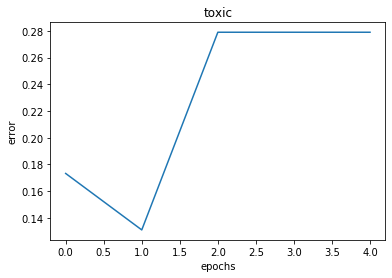

In [27]:
weights = dict()

weights['toxic'], errs = train2('toxic', return_errors=True, eta=1)
plt.plot(range(len(errs)), errs)
plt.xlabel('epochs')
plt.ylabel('error')
plt.title('toxic')
plt.show()

Как видим, та же петрушка, что и ранее. Попробуем уменьшить eta.

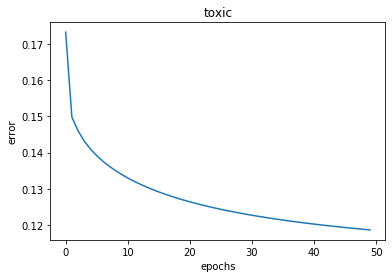

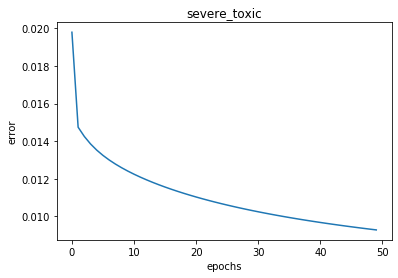

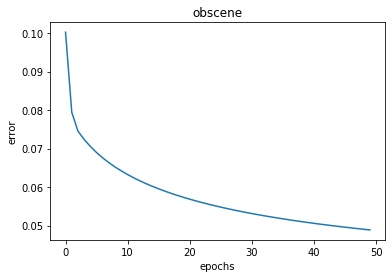

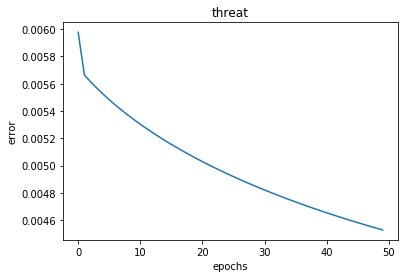

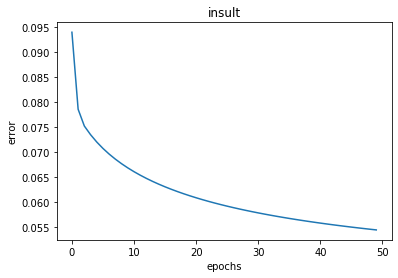

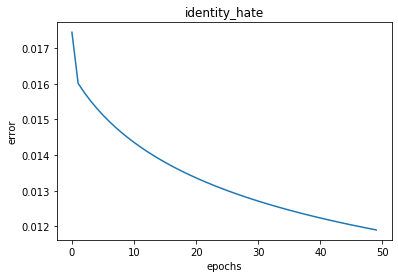

In [28]:
for t in agressive_comment_types:
    weights[t], errs = train2(t, return_errors=True, eta=0.00003, epochs_num=50)
    plt.plot(range(len(errs)), errs)
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.title(t)
    plt.show()

Как видим, картина примерно та же. Попробуем теперь подобрать параметр p.

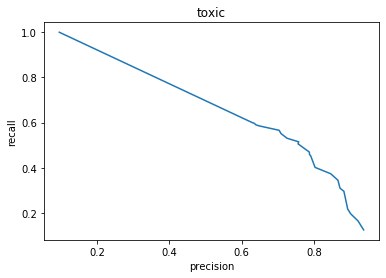

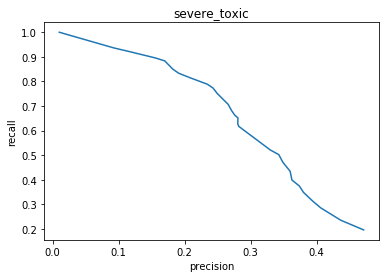

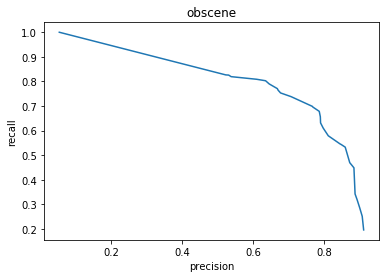

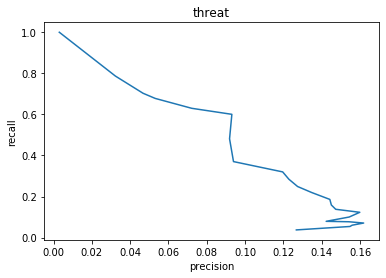

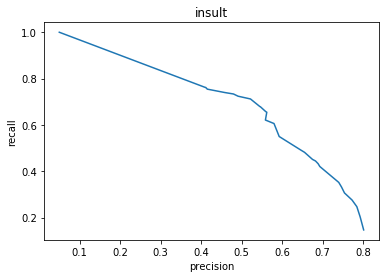

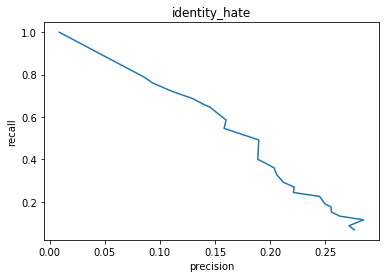

In [29]:
for t in agressive_comment_types:
    precision = []
    recall = []
    for p in np.arange(-1, 1, 0.05):
        pr, rec = precision_recall2(t, p)
        precision.append(pr)
        recall.append(rec)
    plt.plot(precision, recall)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title(t)
    plt.show()

В принципе, если взглянуть на те precision и recall, что мы получали в прошлом методе,  почти ничего не поменялось. Отсюда можно сделать вывод, что нужен в корне другой подход. Взглянем на слова, которые занулил наш алгоритм:

In [30]:
for t in agressive_comment_types:
    for i in range(len(weights[t])):
        if weights[t][i] == 0:
            print(pop_agressive_words[t][i], end=' ')

bot admins jewish respect unblock fan 

Негусто. Радует то, что эти слова и впрямь никакого отношения к классификации явно не имеют (кроме, возможно, jewish). Что ж, на этом мы завершаем нашу работу. Особо значимых результатов она не принесла.  
Для улучшения можно попытаться смотреть не только на входящие слова, но и на пары слов, что увеличило бы вес классификатора, но, возможно, улучшило бы качество.